In [ ]:
# nos aseguramos de trabajar con tensor 2 utilizando la gpu
!pip install tensorflow-gpu==2.0.0-beta1

# Red convolucional - Clasificación de objetos de oficina

#### Implementar una arquitectura convolucional para clasificar los diferentes objetos del punto 1. Se deben generar métricas de desempeño con el fin de seleccionar la arquitectura con mejores resultados.

Modelo implementado en TensorFlow 2.0

Estudiante: Andrés David Tamayo Palomino


In [22]:
# Conceder acceso a Drive para utilizar los archivos 
# alojados allí (solo si se va a correr en colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importamos las librerías a utilizar
import os
import h5py
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.python.client import device_lib 
from preprocess_images import Preprocesar_imagenes
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from keras.preprocessing.image import load_img,img_to_array,array_to_img,save_img

In [ ]:
class Modelo_oficina():
  
  def __init__(self,path):    
    # verificación de disponibilidad de GPU
    if(tf.test.is_gpu_available()):
      print("GPU disponible para entrenar el modelo")
    else:
      print("No hay GPU disponible")
      
    self.path_proyecto = path
    
    # definimos el directorio raiz para guardar los logs
    self.root_logdir = os.path.join(os.curdir, "my_logs")
    
  def cargar_dataset(self):
    """
    Cargamos el archivo h5 con la clase Preprocesar imágenes
    """
    cargar_archivo = Preprocesar_imagenes(self.path_proyecto)
    return cargar_archivo.load_dataset(self.path_proyecto+"base_redimensionada")

  
  def one_hot_y(self,y):
    """
    Convetirmos la variable numérica categórica a one_hot
    """    
    return to_categorical(y)
  
  
  def get_run_logdir(self):
    """
    Path donde vamos a meter nuestros logs nombrado con fecha y hora para que 
    sea diferente en cada ejecución
    """
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(self.root_logdir, run_id)
  
  
  def particion_dataset(self,X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        stratify=y, 
                                                        test_size=0.2,
                                                        random_state=77)       
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                     stratify=y_train, 
                                                     test_size=0.1, 
                                                     random_state=77)      
    
    return X_train,X_val,X_test,y_train,y_val,y_test
  
  
  def normalizar_imagenes(self,train,val,test):    
    """
    normalizamos los pixeles a valores entre 0 y 1 
    """
    train_images, val_images, test_images = train / 255.0, val / 255.0 , test / 255.0
    
    return train_images, val_images, test_images
  
  
  def arquitectura_modelo(self,n_hidden_conv= 1, n_hidden_dense = 1, n_neurons=32, learning_rate=0.001):
    """
    Definición de la arquitectura del modelo, 
    y luego se retorna el modelo compilado
    """
    
    # necesario por error de padding en el maxpooling
    K.set_image_dim_ordering('th')
    
    model = keras.models.Sequential()
    
    model.add(layers.Conv2D(n_neurons, (3, 3), activation='relu', padding='same',input_shape=(64, 64, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    keras.layers.Dropout(0.3)
    
    for i in range(n_hidden_conv+1):
      model.add(layers.Conv2D(n_neurons, (3, 3),padding='same', activation='relu'))
      model.add(layers.BatchNormalization())
      model.add(layers.MaxPooling2D((2, 2)))
      keras.layers.Dropout(0.3)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(n_neurons, activation='relu'))
    model.add(layers.BatchNormalization())
    keras.layers.Dropout(0.3)
    
    for i in range(n_hidden_dense+1):
      model.add(layers.Dense(n_neurons, activation='relu'))
    
    model.add(layers.Dense(18, activation='softmax'))    
    
    optimizer = keras.optimizers.Adam(learning_rate)  
    
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model
    
  def train(self,modelo,X_train,y_train,X_val=None,y_val=None,epocas=50,lote=24):   
    """
    Se entrena un modelo con la arquitectura definida y se retorna el modelo
    y los datos de entrenamiento de este
    """
    
    run_logdir = self.get_run_logdir()

    es = keras.callbacks.EarlyStopping(patience=7)
    rp = keras.callbacks.ReduceLROnPlateau(patience=5,factor=0.5)
    tb = keras.callbacks.TensorBoard(run_logdir)
    # cp = keras.callbacks.ModelCheckpoint("mejor_modelo.h5", save_best_only=True)
       
    
    if X_val is None or y_val is None:      
      history = modelo.fit(X_train, y_train, epochs=epocas,batch_size = lote,
                        validation_split=0.1,
                        callbacks=[es,rp,tb])
    else:
      history = modelo.fit(X_train, y_train, epochs=epocas,batch_size = lote,
                  validation_data=(val_images,y_val),
                  callbacks=[es,rp,tb])

    return history,modelo
  
  
  def tunning_modelo(self,train_images,y_train,val_images,y_val):
    """
    TODO, que los parámetros de tunning se pasen por parametros y no estén quemados
    pero me da pereza
    """
    K.set_image_dim_ordering('th')
    np.random.seed(77)
    
    keras_class = keras.wrappers.scikit_learn.KerasClassifier(self.arquitectura_modelo)

    # tener en cuenta que la puntuación será la opuesta a la del crossentropy
    # porque Scikit-Learn desea puntuaciones, no pérdidas. (es decir, más alto debería ser mejor).
    
    param_distribs = {
        "n_hidden_conv": [1,2,3,4],
        "n_hidden_dense": [1,2,3,4],
        "n_neurons": [16,32,64,128,384,512],
        "learning_rate": [0.0001,0.0003,0.0005],
    }
    
    cnn_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=70, cv=2, verbose=2)

    cnn_search_cv.fit(train_images, y_train, epochs=150,   
                      validation_data = (val_images,y_val),                
                      callbacks=[keras.callbacks.EarlyStopping(patience=7)
                                 ,keras.callbacks.ReduceLROnPlateau(patience=5)])
    
    return cnn_search_cv
  
  
  def resultados_tunning(self,mejor_modelo):
    
    print("Mejores parámetros: \n", mejor_modelo.best_params_)
    
    print("Mejor puntuación:  ",mejor_modelo.best_score_)  
    
    
  def predict(self,modelo,X_test):
    
    return modelo.predict(X_test)

    

In [ ]:
# ubicación del proyecto
path = "/content/drive/My Drive/Synced/u/predictive/Solucion_taller_1/"

In [40]:
modelo = Modelo_oficina(path)

X,y,nombres = modelo.cargar_dataset()

X_train,X_val,X_test,y_train,y_val,y_test = modelo.particion_dataset(X,y)

GPU disponible para entrenar el modelo


In [44]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(19309, 64, 64, 3)
(2146, 64, 64, 3)
(5364, 64, 64, 3)


In [ ]:
# se normalizan las imágenes
train_images, val_images, test_images = modelo.normalizar_imagenes(X_train,X_val,X_test)

### Busqueda de una buena arquitectura

In [ ]:
# se busca la mejor arquitectura entre un grupo de parámetros 
modelo_optimo = modelo.tunning_modelo(train_images,y_train,val_images,y_val)

In [19]:
# los resultados de la mejor arquitectura encontrada
modelo.resultados_tunning(modelo_optimo)

Mejores parámetros: 
 {'n_neurons': 384, 'n_hidden_dense': 2, 'n_hidden_conv': 3, 'learning_rate': 0.0005}
Mejor puntuación:   0.7712465646975809


### Entrenamiento modelo

Una vez encontrada la mejor arquitectura, vamos a entrenar nuestro modelo de forma individual para obtener registros del comportamiento durante su entrenamiento y métricas del rendimiento final del modelo

In [ ]:
arquitectura = modelo.arquitectura_modelo(3,2,384,0.005)

In [ ]:
history,modelo_entrenado = modelo.train(arquitectura,train_images,y_train,val_images,y_val,100,20)

In [55]:
modelo_entrenado.evaluate(test_images,y_test)

5364/5364 [==============================] - 10s 2ms/sample - loss: 0.9886 - accuracy: 0.8043


[0.988602847172021, 0.80425054]

In [ ]:
losses = {key:history.history[key] for key in ['loss', 'val_loss']}
accuracy = {key:history.history[key] for key in ['accuracy', 'val_accuracy']}

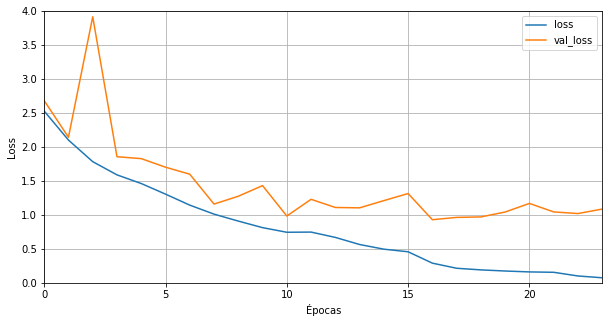

In [95]:
pd.DataFrame(losses).plot(figsize=(10, 5))
plt.gca().set_ylim(0, 4)
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

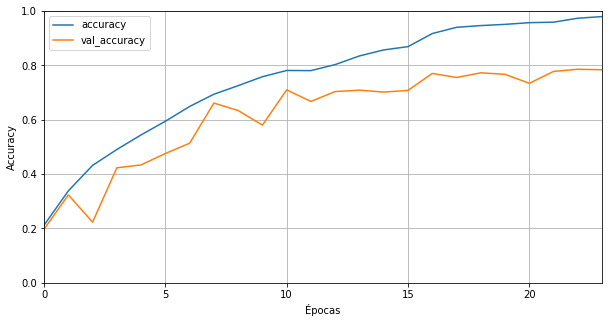

In [98]:
pd.DataFrame(accuracy).plot(figsize=(10, 5))
plt.gca().set_ylim(0, 1)
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [ ]:
# Para ver los logs de entrenamiento en tensorboard
# !tensorboard --logdir=./my_logs --port=6006

modelo_entrenado.save("modelo_propio.h5")

**Conclusiones:**

Se obtiene un accuracy de 80.4% en nuestro modelo

Las gráficas de pérdida y exactitud nos muestran que el modelo tiene un poco de sobreajuste, esto se podría solucionar con image augmentation y tuneando parámetros como el dropout, y también se podría programar la tasa de aprendizaje para que vaya aprendiendo y modificandose durante el entrenamiento para tratar de obtener un mejor resultado en nuestra métrica.